In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("mabel.txt",header=None,on_bad_lines='skip', encoding='utf8')

In [3]:
df.head()

,0,1
0,05/12/19,1:42 pm - Messages to this chat and calls are...
1,05/12/19,1:42 pm - Mabel Infoziant: Hi this is Mabel w...
2,05/12/19,1:42 pm - Mabel Infoziant: What’s your full name
3,05/12/19,1:42 pm - AR❤: Ramisha Rani K
4,05/12/19,1:42 pm - Mabel Infoziant: Ok


In [4]:
df = df.drop(0)


In [5]:
df.columns = ['Date','Chat']
msg=df['Chat'].str.split('-',n=1,expand=True)
df['Time']=msg[0]
msgName=msg[1].str.split(':',n=1,expand=True)
df['Name']=msgName[0]
df['Chat']=msgName[1]
df=df[['Date','Time','Name','Chat']]


In [6]:
df.head()

,Date,Time,Name,Chat
1,05/12/19,1:42 pm,Mabel Infoziant,Hi this is Mabel we just spoke
2,05/12/19,1:42 pm,Mabel Infoziant,What’s your full name
3,05/12/19,1:42 pm,AR❤,Ramisha Rani K
4,05/12/19,1:42 pm,Mabel Infoziant,Ok
5,05/12/19,1:42 pm,Mabel Infoziant,ramisharanik@gmail.com


In [7]:
dataset=df

In [8]:
def sentimentalAnalysis(dataset,colName):
    "Importing necessary package"
    import matplotlib.pyplot as plt
    import seaborn as sns
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sia=SentimentIntensityAnalyzer()
    
    "Dropping null value"
    dataset.dropna(inplace=True)

    "Creating columns"
    dataset['Scores']=dataset[colName].apply(lambda commentText : sia.polarity_scores(commentText))
    dataset['Compound']=dataset['Scores'].apply(lambda score_dict : score_dict['compound'])
    dataset['Positive']  = dataset['Scores'].apply(lambda score_dict: score_dict['pos'])
    dataset['Negative']  = dataset['Scores'].apply(lambda score_dict: score_dict['neg'])
    dataset['Neutral']  = dataset['Scores'].apply(lambda score_dict: score_dict['neu'])

    "Creating final pos or neg using compound score"
    dataset['comp_score'] = dataset['Compound'].apply(lambda c:  'pos' if c>=0 else 'neg')

    "Checking how many pos and neg"
    posneg=pd.DataFrame(dataset['comp_score'].value_counts())

    return dataset,posneg
    

In [9]:
data,posneg_count = sentimentalAnalysis(dataset,colName='Chat')

In [10]:
data.head()

,Date,Time,Name,Chat,Scores,Compound,Positive,Negative,Neutral,comp_score
1,05/12/19,1:42 pm,Mabel Infoziant,Hi this is Mabel we just spoke,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,0.0,1.0,pos
2,05/12/19,1:42 pm,Mabel Infoziant,What’s your full name,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,0.0,1.0,pos
3,05/12/19,1:42 pm,AR❤,Ramisha Rani K,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,0.0,1.0,pos
4,05/12/19,1:42 pm,Mabel Infoziant,Ok,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.296,1.0,0.0,0.0,pos
5,05/12/19,1:42 pm,Mabel Infoziant,ramisharanik@gmail.com,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,0.0,1.0,pos


In [11]:
posneg_count

,count
comp_score,
pos,48
neg,2


In [12]:
from sklearn.feature_extraction.text import  CountVectorizer, ENGLISH_STOP_WORDS


# Step 1: Define custom stop words
custom_stop_words = {'hi', 'yes', 'mam','kk','ok','sure','send'}

# Step 2: Combine with default stop words
extended_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

# Step 3: Use the extended stop words in the vectorizer
count_vect = CountVectorizer(max_df=0.95,min_df=2,stop_words=extended_stop_words)
dfm = count_vect.fit_transform(dataset['Chat'])

In [13]:
count_vect.get_feature_names_out()

array(['abstract', 'abstracts', 'ask', 'church', 'details', 'finiliaze',
       'just', 'know', 'meeting', 'ml', 'need', 'number', 'office',
       'phone', 'project', 'ramisha', 'read', 'share', 'soon', 'start',
       'students', 'think', 'tomorrow', 'vignesh', 'yeah'], dtype=object)

In [14]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(dfm)

NMF(n_components=5, random_state=42)

In [15]:
for index,topic in enumerate(nmf_model.components_):
    result=([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print(result)

['abstracts', 'ml', 'need', 'share', 'know', 'ask', 'phone', 'students', 'number', 'office']
['ask', 'abstracts', 'meeting', 'soon', 'yeah', 'church', 'office', 'know', 'just', 'tomorrow']
['number', 'meeting', 'phone', 'students', 'ramisha', 'know', 'soon', 'share', 'need', 'details']
['abstracts', 'start', 'number', 'ml', 'project', 'finiliaze', 'details', 'ask', 'think', 'vignesh']
['soon', 'share', 'church', 'yeah', 'need', 'ramisha', 'start', 'abstracts', 'read', 'abstract']


In [16]:
topic_results=nmf_model.transform(dfm)

In [17]:
dataset['Topic']=topic_results.argmax(axis=1)

In [18]:
dataset

,Date,Time,Name,Chat,Scores,Compound,Positive,Negative,Neutral,comp_score,Topic
1,05/12/19,1:42 pm,Mabel Infoziant,Hi this is Mabel we just spoke,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,1
2,05/12/19,1:42 pm,Mabel Infoziant,What’s your full name,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,0
3,05/12/19,1:42 pm,AR❤,Ramisha Rani K,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,2
4,05/12/19,1:42 pm,Mabel Infoziant,Ok,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.2960,1.000,0.000,0.000,pos,0
5,05/12/19,1:42 pm,Mabel Infoziant,ramisharanik@gmail.com,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,0
6,05/12/19,1:43 pm,Mabel Infoziant,Your email Id?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,0
7,05/12/19,1:43 pm,AR❤,Yes Mam,"{'neg': 0.0, 'neu': 0.27, 'pos': 0.73, 'compou...",0.4019,0.730,0.000,0.270,pos,0
8,05/12/19,1:43 pm,Mabel Infoziant,I will send 2 abstracts for u to start working,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,4
9,05/12/19,1:43 pm,AR❤,Yeah mam,"{'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'comp...",0.2960,0.688,0.000,0.312,pos,4
10,05/12/19,1:43 pm,Mabel Infoziant,Give me the list that u have too,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,0


In [22]:

# Word Cloud

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ELCOT\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

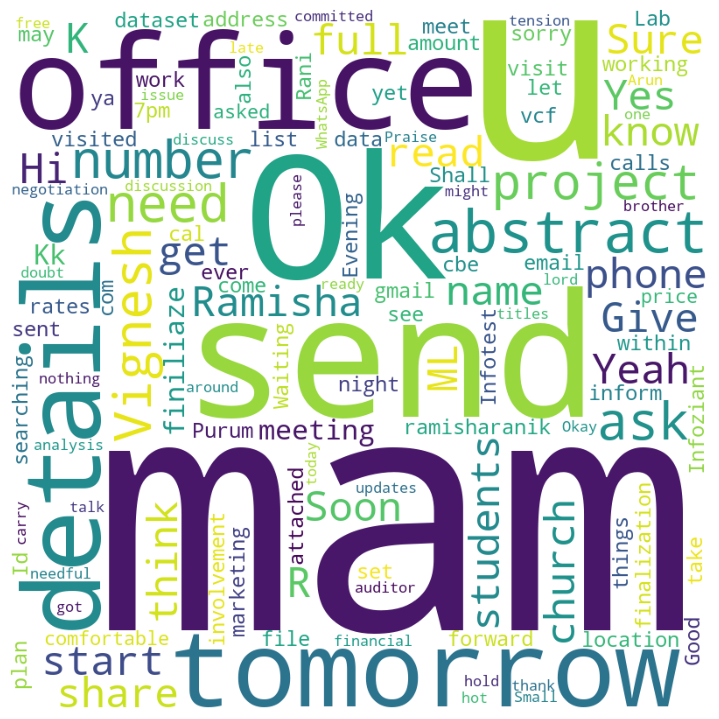

Successfully created


In [23]:
comment_words = []
stoplist = stopwords.words('english')
stoplist.extend(['omitted', 'voice','missed','call','video','deleted','media','message'])
wordcloudss="This function saves image"
dataset.index=range(dataset.shape[0])
for i in range(1,len(dataset)): 
    comment_words.append(dataset['Chat'][i])
    vv=" ".join(comment_words)          
    wordcloud = WordCloud(width = 800, height = 800, 
                                background_color ='white', 
                                      stopwords = stoplist, 
                                      min_font_size = 10).generate(vv)         
plt.figure(figsize = (9, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 
#plt.savefig('wordcloud.PNG')
plt.show() 
print("Successfully created")
wordcloudss="This function saves image"